In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import torch.nn as nn
import torch.optim
from tqdm.auto import tqdm
from statannotations.Annotator import Annotator


import multitask.dataset as dataset
from multitask.models.individual import get_individual_model
from multitask.models.individual import hooks as hooks_individual
from multitask.models.parallel import get_parallel_model
from multitask.models.parallel import hooks as hooks_parallel
from multitask.models.task_switching import get_task_model
from multitask.models.task_switching import hooks as hooks_task_switching
from multitask.utils.argparse import check_runs
from multitask.utils.training import get_device

In [2]:
plt.style.use('../style/plots.mplstyle')

seaborn_props = {
    'boxprops': {'edgecolor':'black', 'linewidth': 1},
    'medianprops': {'color':'black', 'linewidth': 1},
    'whiskerprops': {'color':'black', 'linewidth': 1},
    'capprops': {'color':'black', 'linewidth': 1}
}

In [3]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))
num_tasks = len(tasks_names)

print(f'Num. Tasks: {num_tasks}')
print(f'Indices Contexts: {idxs_contexts}')

Num. Tasks: 2
Indices Contexts: [0, 1, 2, 3, 4]


In [4]:
path_data = os.path.join('..', '..', 'data')
path_model_individual = os.path.join('..', '..', 'results', 'individual')
path_model_parallel = os.path.join('..', '..', 'results', 'parallel')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [5]:
path_figure = os.path.join('svg', 'figureS11a_acc_boxplots.svg')

In [6]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}
data_folder_task_switching = check_runs(path_model_task_switching, parameters)

parameters['idxs_contexts'] = None
data_folder_individual = check_runs(path_model_individual, parameters)
data_folder_parallel = check_runs(path_model_parallel, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_18_47)
Found simulation in ../../results/individual with the same parameters (2022-09-27_22_43_04)
Found simulation in ../../results/parallel with the same parameters (2022-09-27_23_18_55)


In [7]:
pickle_data_individual = os.path.join(data_folder_individual, 'data.pickle')
with open(pickle_data_individual, 'rb') as handle:
    results_individual = pickle.load(handle)

pickle_data_parallel = os.path.join(data_folder_parallel, 'data.pickle')
with open(pickle_data_parallel, 'rb') as handle:
    results_parallel = pickle.load(handle)

pickle_data_task_switching = os.path.join(data_folder_task_switching, 'data.pickle')
with open(pickle_data_task_switching, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [8]:
seeds_individual = sorted(list(results_individual.keys()))
seeds_parallel = sorted(list(results_parallel.keys()))
seeds_task_switching = sorted(list(results_task_switching.keys()))
assert seeds_individual == seeds_parallel == seeds_task_switching

In [9]:
valid_acc_individual = {task_name: np.zeros((num_runs, )) for task_name in tasks_names}
valid_acc_parallel = {task_name: np.zeros((num_runs, ))  for task_name in tasks_names}
valid_acc_task_switching = {task_name: np.zeros((num_runs, )) for task_name in tasks_names}

valid_acc_individual['joint'] = np.zeros((num_runs, ))
valid_acc_parallel['joint'] = np.zeros((num_runs, ))
valid_acc_task_switching['joint'] = np.zeros((num_runs, ))

In [10]:
df_results_all = pd.DataFrame({}, columns=['Acc', 'Model', 'Task'])

for i_seed, seed in enumerate(seeds_individual):
    for task_name in tasks_names:
        min_idx_individual = -1
        min_valid_acc_individual = results_individual[seed][task_name]['results']['valid_acc'][min_idx_individual]
        valid_acc_individual[task_name][i_seed] = min_valid_acc_individual

        min_idx_parallel = -1
        min_valid_acc_parallel = results_parallel[seed]['results']['valid_acc'][task_name][min_idx_parallel]
        valid_acc_parallel[task_name][i_seed] = min_valid_acc_parallel

        min_idx_task_switching = -1
        min_valid_acc_task_switching = results_task_switching[seed]['results']['valid_acc'][task_name][min_idx_task_switching]
        valid_acc_task_switching[task_name][i_seed] = min_valid_acc_task_switching

In [11]:
results_individual[seed].keys()

dict_keys(['indices', 'parity', 'value'])

In [12]:
device = get_device()
criterion = nn.CrossEntropyLoss()
tasks = dataset.get_tasks_dict(tasks_names, root=path_data)

Running on CPU.


In [13]:
# Calculate Joint Individual
joint_individual = np.zeros((num_runs, num_test, num_tasks))

for i_seed, seed in tqdm(enumerate(seeds_individual), total=len(seeds_individual)):
    indices = results_individual[seed]['indices']
    test_model = get_individual_model(num_hidden, device)
    test_sampler = dataset.SequentialSampler(indices['test'])

    for i_task, (task_name, task_dataset) in enumerate(tasks.items()):
        saved_model = results_individual[seed][task_name]['model']
        test_model.load_state_dict(saved_model)
        test_model = test_model.to(device)
        
        test_sampler = dataset.SequentialSampler(indices['test'])
        testloader = torch.utils.data.DataLoader(task_dataset,
                                                 sampler=test_sampler,
                                                 batch_size=100)

        acc_test, _ = hooks_individual.get_layer_activations(test_model,
                                                             testloader,
                                                             criterion,
                                                             device=device,
                                                             disable=True)
        joint_individual[i_seed][:, i_task] = acc_test.flatten()

valid_acc_individual['joint'] = np.prod(joint_individual, axis=2).mean(axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
parallel_datasets = {}
for task_name in tasks_names:
    parallel_datasets[task_name] = tasks[task_name]

parallel_tasks = dataset.MultilabelTasks(parallel_datasets)

In [15]:
# Calculate Joint Parallel
joint_parallel = np.zeros((num_runs, num_test, num_tasks))

for i_seed, seed in tqdm(enumerate(seeds_parallel), total=num_runs):
    saved_model = results_parallel[seed]['model']
    test_model = get_parallel_model(num_tasks,
                               num_hidden,
                               device)
    test_model.load_state_dict(saved_model)
    test_model = test_model.to(device)
    
    indices = results_parallel[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    parallel_testloader = torch.utils.data.DataLoader(parallel_tasks,
                                                      sampler=test_sampler,
                                                      batch_size=batch_size)

    numbers = parallel_datasets[tasks_names[0]].numbers
    numbers = numbers[indices['test']]
    
    acc_test, _ = hooks_parallel.get_layer_activations(test_model,
                                                       parallel_testloader,
                                                       criterion=criterion,
                                                       device=device,
                                                       disable=True)

    for i_task, task_name in enumerate(tasks_names):                  
            joint_parallel[i_seed][:, i_task] = acc_test[task_name].flatten()
    

valid_acc_parallel['joint'] = np.prod(joint_parallel, axis=2).mean(axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
tasks_datasets = dataset.get_tasks_dict(tasks_names,
                                        root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [17]:
# Calculate Joint Task-Switching
joint_task_switching = np.zeros((num_runs, num_test, num_tasks))

for i_seed, seed in tqdm(enumerate(seeds_task_switching), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    acc_test, _ = hooks_task_switching.get_layer_activations(model,
                                                             tasks_testloader,
                                                             criterion,
                                                             device=device,
                                                             disable=True)

    for i_task, task_name in enumerate(tasks_names):                  
        joint_task_switching[i_seed][:, i_task] = acc_test[task_name].flatten()

valid_acc_task_switching['joint'] = np.prod(joint_task_switching, axis=2).mean(axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
df_results_all = pd.DataFrame({}, columns=['Acc', 'Model', 'Task'])

for task_name in tasks_names + ['joint']:
    task_name_capitalized = task_name.capitalize()

    df_results_individual = pd.DataFrame({'Acc': valid_acc_individual[task_name], 'Model': 'Sequential', 'Task': task_name_capitalized})
    df_results_parallel = pd.DataFrame({'Acc': valid_acc_parallel[task_name], 'Model': 'Parallel', 'Task': task_name_capitalized})
    df_results_task_switching = pd.DataFrame({'Acc': valid_acc_task_switching[task_name], 'Model': 'Task-Switching', 'Task': task_name_capitalized})
    df_results_all = pd.concat((df_results_all, df_results_individual, df_results_parallel, df_results_task_switching))

df_results_all.loc[df_results_all['Task'] == 'Fibonacci', 'Task'] = 'Fib.'
df_results_all.loc[df_results_all['Task'] == 'Multiples3', 'Task'] = 'Mul. 3'

df_results_all.reset_index(drop=True, inplace=True)

In [19]:
# Capitalize tasks, and prevent Mul3 to not appear in the statannotations

if num_tasks == 2:
    new_task_names = ['Parity', 'Value', 'Joint']
else:
    new_task_names = ['Parity', 'Value', 'Prime', 'Fib.', 'Mul. 3', 'Joint']

In [20]:
box_pairs = []

for task in new_task_names:

    acc_sequential = df_results_all[(df_results_all['Task'] == task) & (df_results_all['Model'] == 'Sequential')]['Acc'].tolist()
    acc_parallel = df_results_all[(df_results_all['Task'] == task) & (df_results_all['Model'] == 'Parallel')]['Acc'].tolist()
    acc_task_switching = df_results_all[(df_results_all['Task'] == task) & (df_results_all['Model'] == 'Task-Switching')]['Acc'].tolist()

    _, pvalue_sequential_parallel = stats.wilcoxon(acc_sequential, acc_parallel)
    _, pvalue_sequential_ts = stats.wilcoxon(acc_sequential, acc_task_switching)
    _, pvalue_parallel_ts = stats.wilcoxon(acc_parallel, acc_task_switching)

    if pvalue_sequential_parallel <= 0.05:
        box_pairs.append(((task, 'Sequential'), (task, 'Parallel')))

    if pvalue_sequential_ts <= 0.05:
        box_pairs.append(((task, 'Sequential'), (task, 'Task-Switching')))

    if pvalue_parallel_ts <= 0.05:
        box_pairs.append(((task, 'Parallel'), (task, 'Task-Switching')))

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Joint_Sequential vs. Joint_Parallel: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
Joint_Sequential vs. Joint_Task-Switching: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00


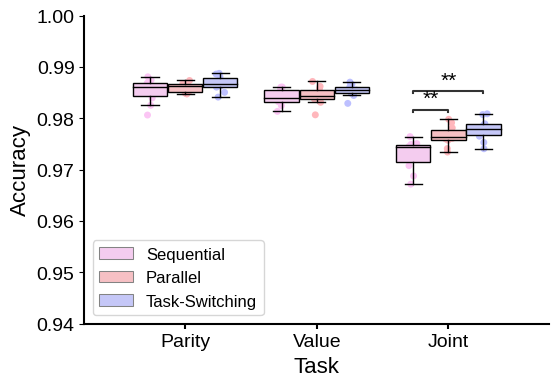

In [21]:
num_layers = len(num_hidden)
num_units = num_hidden[0]
num_tasks = len(tasks_names)

fig = plt.figure(figsize=(6, 4))
sns.boxplot(x='Task', y='Acc', hue='Model', data=df_results_all, showfliers=False, **seaborn_props)
sns.stripplot(x='Task', y='Acc', hue='Model', data=df_results_all, dodge=True, zorder=-1)

plt.xlabel('Task')
plt.ylabel('Accuracy')

ax = plt.gca()
annotator = Annotator(
    ax,
    data=df_results_all,
    x='Task',
    y='Acc',
    hue='Model',
    pairs=box_pairs)

annotator.configure(test="Wilcoxon",
                    text_format="star",
                    loc="inside",
                    fontsize=15)
annotator.apply_and_annotate()

plt.ylim(0.94, 1.0)

    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:3], labels=labels[:3],
          loc='lower left')

fig.savefig(path_figure,
            transparent=True,
            bbox_inches='tight')
plt.show()

In [22]:
print('Sequential')
for task in tasks_names + ['joint']:
    filtered_df = df_results_all[(df_results_all['Task'] == task.capitalize()) & (df_results_all['Model'] == 'Sequential')]
    mean_acc = filtered_df['Acc'].mean()
    mean_std = filtered_df['Acc'].std()
    print(f'{task}: {mean_acc:.4} ± {mean_std:.4f}')

print('\nParallel')
for task in tasks_names + ['joint']:
    filtered_df = df_results_all[(df_results_all['Task'] == task.capitalize()) & (df_results_all['Model'] == 'Parallel')]
    mean_acc = filtered_df['Acc'].mean()
    mean_std = filtered_df['Acc'].std()
    print(f'{task}: {mean_acc:.4} ± {mean_std:.4f}')

print('\nTask-Switching')
for task in tasks_names + ['joint']:
    filtered_df = df_results_all[(df_results_all['Task'] == task.capitalize()) & (df_results_all['Model'] == 'Task-Switching')]
    mean_acc = filtered_df['Acc'].mean()
    mean_std = filtered_df['Acc'].std()
    print(f'{task}: {mean_acc:.4} ± {mean_std:.4f}')

Sequential
parity: 0.9854 ± 0.0023
value: 0.9841 ± 0.0016
joint: 0.973 ± 0.0031

Parallel
parity: 0.986 ± 0.0009
value: 0.9844 ± 0.0018
joint: 0.9766 ± 0.0020

Task-Switching
parity: 0.9868 ± 0.0015
value: 0.9854 ± 0.0012
joint: 0.9778 ± 0.0022


In [23]:
import scipy.stats as stats

def run_wilcoxon(acc_group1, acc_group2):

    _, pvalue = stats.wilcoxon(acc_group1, acc_group2)

    if 0.001 < pvalue <= 0.05:
        pvalue_str = f'{pvalue} (*)'
    elif pvalue <= 0.001:
        pvalue_str = f'{pvalue} (**)'
    else:
        pvalue_str = f'{pvalue} (No significance)'

    return pvalue_str

for task in tasks_names + ['joint']:
    acc_individual = df_results_all[(df_results_all['Task'] == task.capitalize()) & (df_results_all['Model'] == 'Sequential')]['Acc'].tolist()
    acc_parallel = df_results_all[(df_results_all['Task'] == task.capitalize()) & (df_results_all['Model'] == 'Parallel')]['Acc'].tolist()
    acc_task_switching = df_results_all[(df_results_all['Task'] == task.capitalize()) & (df_results_all['Model'] == 'Task-Switching')]['Acc'].tolist()

    print(task)
    print(f'Individual - Parallel: {run_wilcoxon(acc_individual, acc_parallel)}')
    print(f'Individual - Task Switching: {run_wilcoxon(acc_individual, acc_task_switching)}')
    print(f'Parallel - Task Switching: {run_wilcoxon(acc_parallel, acc_task_switching)}')
    print()


parity
Individual - Parallel: 0.556640625 (No significance)
Individual - Task Switching: 0.16015625 (No significance)
Parallel - Task Switching: 0.431640625 (No significance)

value
Individual - Parallel: 1.0 (No significance)
Individual - Task Switching: 0.130859375 (No significance)
Parallel - Task Switching: 0.10546875 (No significance)

joint
Individual - Parallel: 0.009765625 (*)
Individual - Task Switching: 0.005859375 (*)
Parallel - Task Switching: 0.232421875 (No significance)

